In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

crimes_schema = StructType([StructField("INCIDENT_NUMBER", StringType(), True),
                            StructField("OFFENSE_CODE", StringType(), True),
                            StructField("OFFENSE_CODE_GROUP", StringType(), True),
                            StructField("OFFENSE_DESCRIPTION", StringType(), True),
                            StructField("DISTRICT", StringType(), True),
                            StructField("REPORTING_AREA", StringType(), True),
                            StructField("SHOOTING", StringType(), True),
                            StructField("OCCURRED_ON_DATE", TimestampType(), True),
                            StructField("YEAR", IntegerType(), True),
                            StructField("MONTH", IntegerType(), True),
                            StructField("DAY_OF_WEEK", StringType(), True),
                            StructField("HOUR", IntegerType(), True),
                            StructField("UCR_PART",StringType(), True),
                            StructField("STREET", StringType(), True),
                            StructField("Lat", StringType(), True),
                            StructField("Long", StringType(), True),
                            StructField("Location", StringType(), True)])

spark = SparkSession.builder.appName("Crimes in boston").getOrCreate()

crimes = spark.read.csv("./data/BostenCrime.csv", header = True, schema = crimes_schema)

In [2]:
Years = crimes.select("YEAR").distinct().sort("YEAR", ascending = False).take(10)

Years

[Row(YEAR=2019),
 Row(YEAR=2018),
 Row(YEAR=2017),
 Row(YEAR=2016),
 Row(YEAR=2015)]

In [3]:
crimes

DataFrame[INCIDENT_NUMBER: string, OFFENSE_CODE: string, OFFENSE_CODE_GROUP: string, OFFENSE_DESCRIPTION: string, DISTRICT: string, REPORTING_AREA: string, SHOOTING: string, OCCURRED_ON_DATE: timestamp, YEAR: int, MONTH: int, DAY_OF_WEEK: string, HOUR: int, UCR_PART: string, STREET: string, Lat: string, Long: string, Location: string]

## Hourly based monthly data

In [4]:
crimes.groupBy("Month").count().orderBy("MONTH").show(12)
crimes.groupBy("YEAR").count().orderBy("YEAR").show()

+-----+-----+
|Month|count|
+-----+-----+
|    1|31549|
|    2|28695|
|    3|32093|
|    4|31867|
|    5|35098|
|    6|39293|
|    7|43853|
|    8|44732|
|    9|42571|
|   10|34286|
|   11|31460|
|   12|31323|
+-----+-----+

+----+------+
|YEAR| count|
+----+------+
|2015| 53597|
|2016| 99430|
|2017|101338|
|2018| 98888|
|2019| 73567|
+----+------+



In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_crime_per_hour_perMonth(hour):

    x_axis = ['Jan', 'Feb', 'Mrt', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']#i+1 for i in range(0,11)]
    y_axis = []
    
    result = crimes.filter("HOUR="+hour).groupBy("MONTH").count().orderBy("MONTH")
    data = result.take(12)
    for i in range(0, 12):
        y_axis.append(data[i][1])

    fig1 = plt.figure(figsize=(7, 7))
    fig1.suptitle('Crimes per month per within a hour', fontsize=14)
    ax = fig1.add_subplot(111)
    ax.set_xlabel('month')
    ax.set_ylabel('Crime')
    ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
    plt.show()
    
    return

In [6]:
from IPython.display import HTML

time = '12'

form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Hour : <input id='hour' type='range' min='0' max='23' step='1' value='12' onchange='set_vars()'/>
</div>"""

javascript = """
<script type="text/Javascript">
    let kernelCell = 8;

    function set_vars(){
        var time = document.getElementById('hour').value;
        var kernel = IPython.notebook.kernel;
        
        kernel.execute('time = "' + time + '"');
        cell = IPython.notebook.get_cell(kernelCell);
        cell.execute();
        cell.focus_cell(kernelCell);
    }
</script>
"""

HTML(form + javascript)

Time: 12


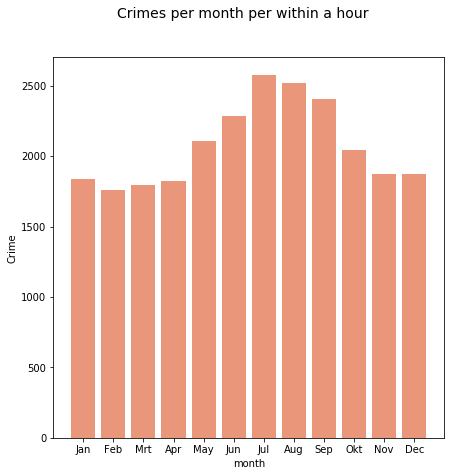

In [7]:
print('Time: ' + str(time))
show_crime_per_hour_perMonth(time)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

print("Crime per hour")

x_axis = [i for i in range(24)]
y_axis = []

result = crimes.groupBy("Hour").count().orderBy("HOUR")

data = result.take(24)
for i in range(0, 24):
    y_axis.append(data[i][1])

Crime per hour


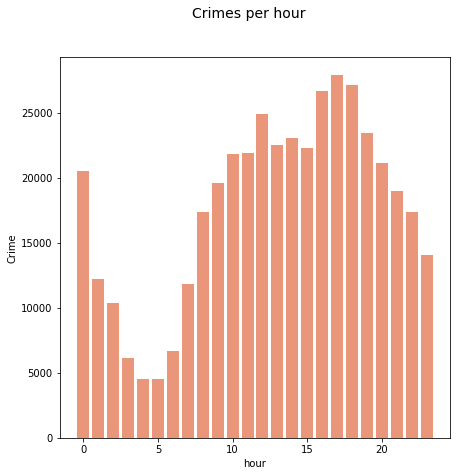

In [9]:
y_axis
    
fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle('Crimes per hour', fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('hour')
ax.set_ylabel('Crime')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

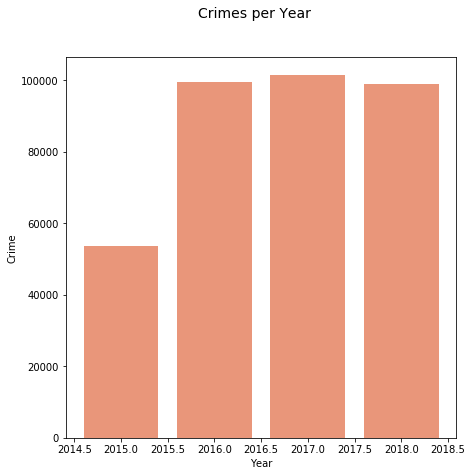

In [10]:
x_axis = []
y_axis = []

result = crimes.groupBy("YEAR").count().orderBy("YEAR")

data = result.take(4)

for i in range(0,4):
    x_axis.append(data[i][0])
    y_axis.append(data[i][1])

fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle('Crimes per Year', fontsize=14)
ax = fig1.add_subplot(111)
ax.set_xlabel('Year')
ax.set_ylabel('Crime')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

In [11]:
from folium.plugins import HeatMap
import folium

def getData(item):
    try:
        return [float(item[0]), float(item[1])]
    except:
        return [0, 0]

crime_long_lat  = crimes.groupBy("Lat","Long").count().sort('count', ascending  = False).limit(9999).collect()
crime_long_lat.pop(0)
long_lat = [getData(item) for item in crime_long_lat]


first_map = folium.Map(
    location=[42.34862382, -71.08277637],
    tiles='Stamen Toner',
    zoom_start=13
)
HeatMap(long_lat,name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=10, gradient=None, overlay=True, control=True, show=True).add_to(first_map)

first_map

In [12]:
def displayMap(year):
    crime_long_lat  = crimes.filter("YEAR="+year).groupBy("Lat","Long").count().sort('count', ascending  = False).limit(9999).collect()
    crime_long_lat.pop(0)
    long_lat = [getData(item) for item in crime_long_lat]

    yearMap = folium.Map(
        location=[42.34862382, -71.08277637],
        tiles='Stamen Toner',
        zoom_start=13
    )
    HeatMap(long_lat,name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=10, gradient=None, overlay=True, control=True, show=True).add_to(yearMap)

    return yearMap

In [13]:
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Year : <input id='year' type='range' min='"""+ str(Years[0][0] - len(Years) + 1) + """' max='"""+ str(Years[0][0]) + """' step='1' value='"""+ str(Years[0][0] - len(Years) + 2) + """' onchange='set_year()'/>
</div>"""

javascript = """
<script type="text/Javascript">
    let yearCell = 14;

    function set_year(){
        var time = document.getElementById('year').value;
        var kernel = IPython.notebook.kernel;
        
        kernel.execute('year = "' + time + '"');
        cell = IPython.notebook.get_cell(yearCell);
        cell.execute();
        cell.focus_cell(yearCell);
    }
</script>
"""

year = '2016'

#Years[0][0] - len(Years) - 1
HTML(form + javascript)

In [14]:
print("Heat map of Year: " + str(year))

yearMap = displayMap(year)
yearMap

Heat map of Year: 2016


In [15]:
result = crimes.groupBy("DISTRICT").count().orderBy("Count")
result.show()

+--------+-----+
|DISTRICT|count|
+--------+-----+
|    null| 2170|
|     A15| 8643|
|      A7|17173|
|      E5|17746|
|     E18|23370|
|     E13|23442|
|     D14|26811|
|      C6|31043|
|      A1|47713|
|      B3|48271|
|      D4|55167|
|     C11|57306|
|      B2|67965|
+--------+-----+



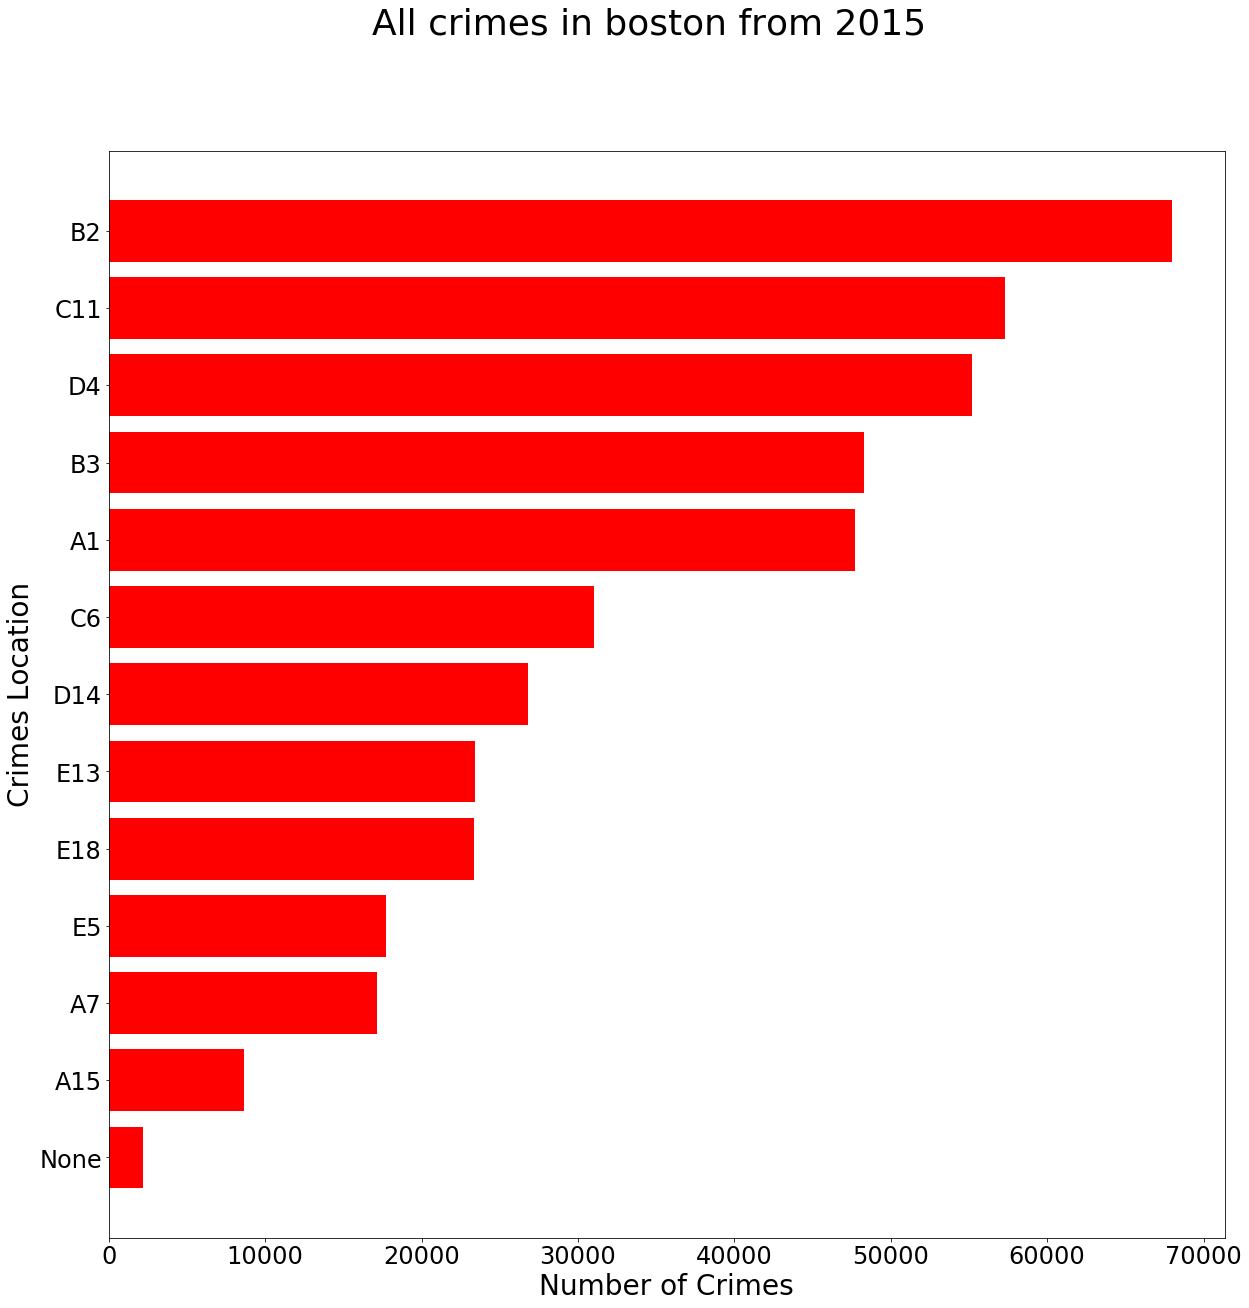

In [16]:
location = [str(item[0]) for item in result.limit(20).collect()]
count = [item[1] for item in result.limit(20).collect()]

x_axis = [i for i in location] 
y_axis= [i for i in count]

fig = plt.figure(figsize=(20,20))
fig.suptitle('All crimes in boston from 2015', fontsize=36)
 
plt.xlabel("Number of Crimes", fontsize = 28)
plt.ylabel("Crimes Location", fontsize = 28)
plt.barh(x_axis,y_axis,color = "red")
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()

In [17]:
result = crimes.groupBy("SHOOTING").count().orderBy("count")
result.show()

+--------+------+
|SHOOTING| count|
+--------+------+
|       Y|  1747|
|    null|425073|
+--------+------+



In [18]:
result = crimes.groupBy("OFFENSE_DESCRIPTION").count().filter("count > 500").sort('count', ascending  = True)
result.show()

+--------------------+-----+
| OFFENSE_DESCRIPTION|count|
+--------------------+-----+
|VIOLATION - CITY ...|  512|
|        EVADING FARE|  526|
|AUTO THEFT - LEAS...|  541|
| LARCENY PICK-POCKET|  549|
|M/V ACCIDENT - IN...|  559|
|PROPERTY - STOLEN...|  565|
|M/V ACCIDENT - IN...|  574|
|VAL - OPERATING W...|  587|
|DRUGS - POSS CLASS C|  612|
|OPERATING UNDER T...|  623|
|FIRE REPORT - CAR...|  663|
|   M/V PLATES - LOST|  666|
|ROBBERY - COMMERCIAL|  696|
|DRUGS - POSS CLASS E|  715|
|NOISY PARTY/RADIO...|  742|
|     ROBBERY - OTHER|  780|
|MISSING PERSON - ...|  827|
|       OTHER OFFENSE|  836|
|BURGLARY - RESIDE...|  851|
|WEAPON - OTHER - ...|  855|
+--------------------+-----+
only showing top 20 rows



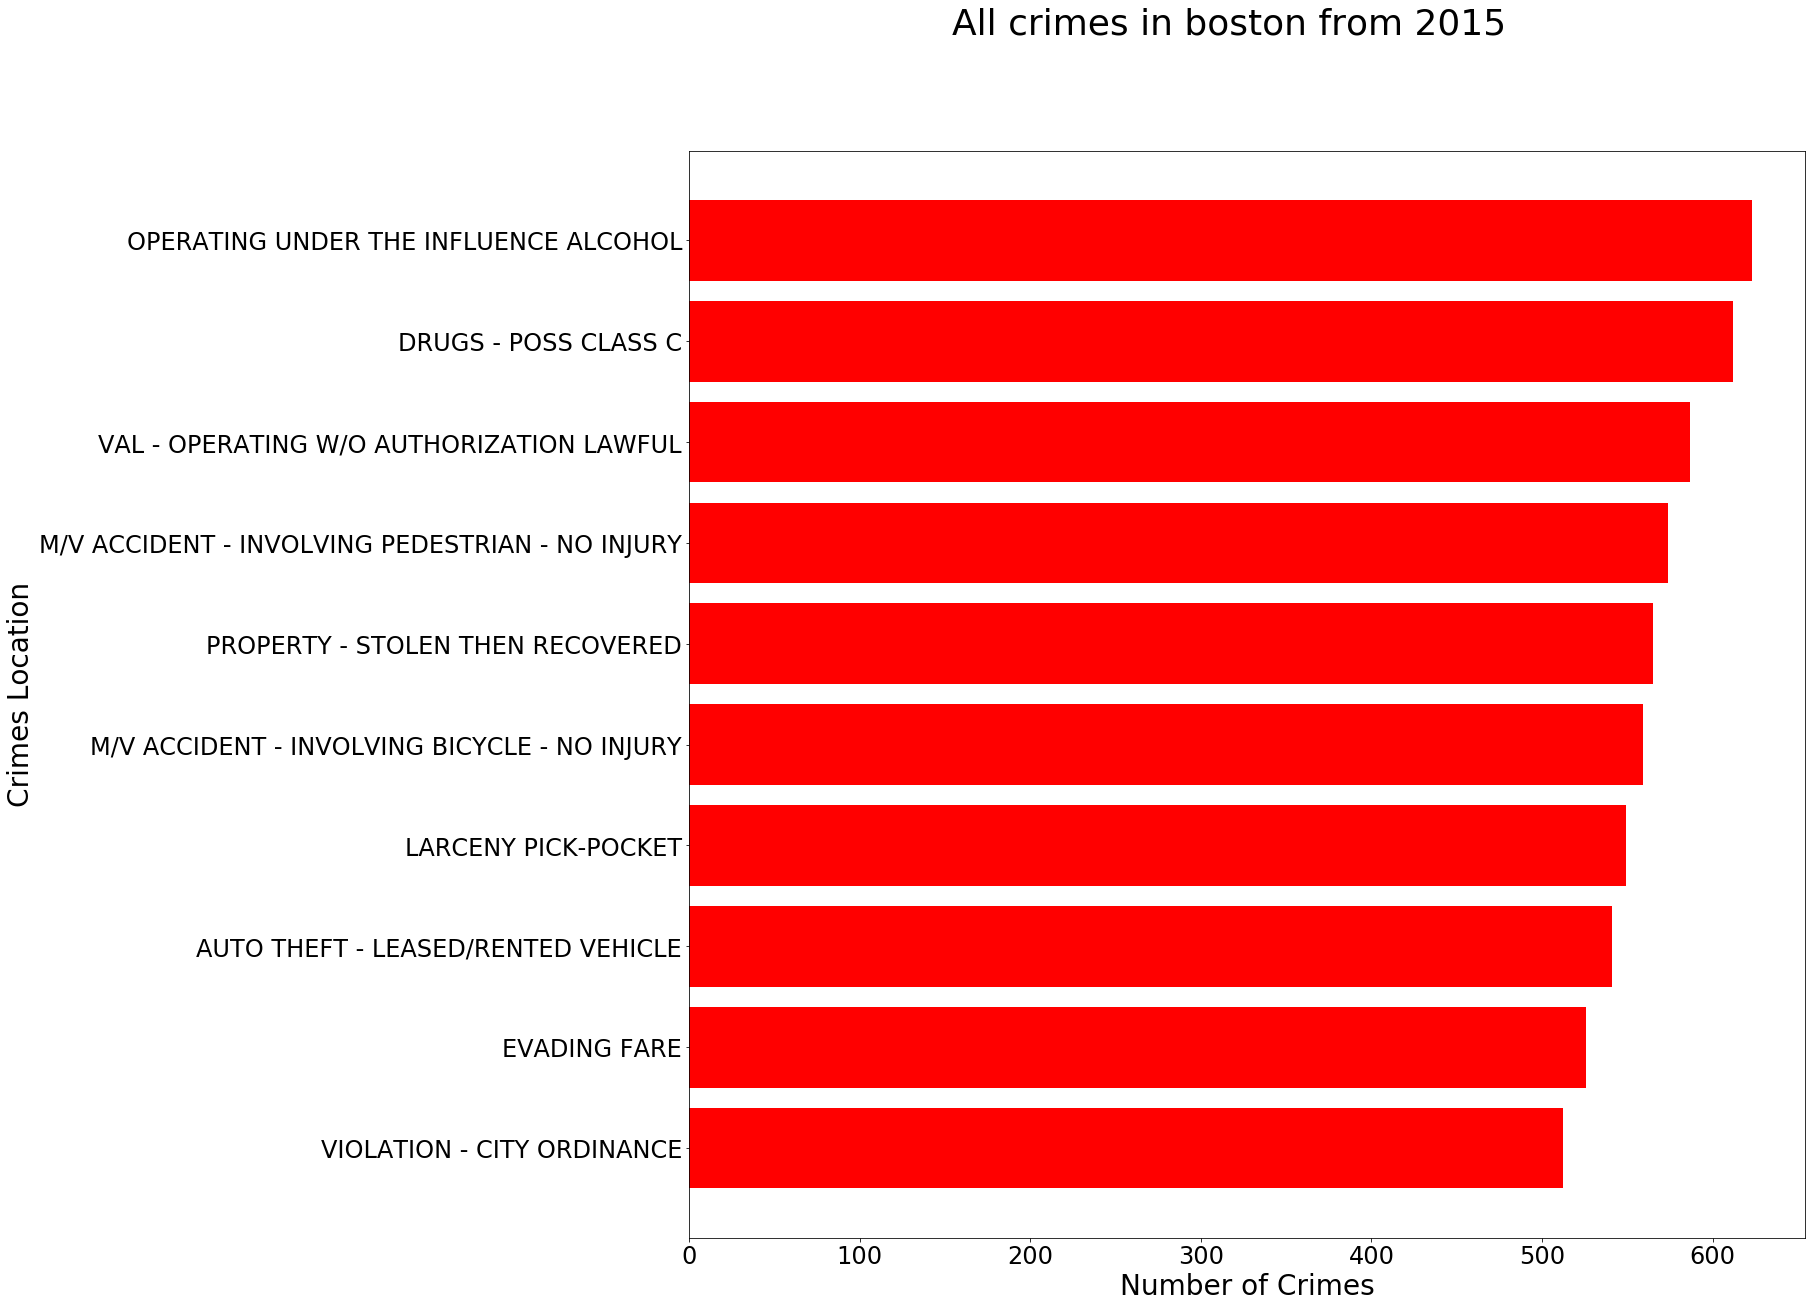

In [19]:
location = [str(item[0]) for item in result.limit(10).collect()]
count = [item[1] for item in result.limit(10).collect()]

x_axis = [i for i in location] 
y_axis= [i for i in count]

fig = plt.figure(figsize=(20,20))
fig.suptitle('All crimes in boston from 2015', fontsize=36)
 
plt.xlabel("Number of Crimes", fontsize = 28)
plt.ylabel("Crimes Location", fontsize = 28)
plt.barh(x_axis,y_axis,color = "red")
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()

In [20]:
from datetime import datetime
from pyspark.sql.functions import col,udf
myfunc =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
df =crimes.withColumn('OCCURRED_ON_DATE',myfunc(col('OCCURRED_ON_DATE'))).drop('OCCURRED_ON_DATE')


#data = df.groupBy('Year').count().show()
data = df.groupBy('Year').count().sort('Year').limit(10).collect()
count = [item[1] for item in data]
year = [item[0] for item in data]
data

[Row(Year=2015, count=53597),
 Row(Year=2016, count=99430),
 Row(Year=2017, count=101338),
 Row(Year=2018, count=98888),
 Row(Year=2019, count=73567)]

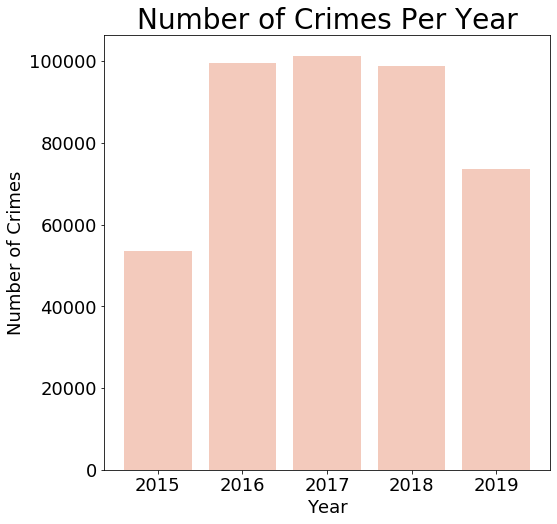

In [21]:
x_axis = [i for i in year] 
y_axis= [i for i in count]



fig1 = plt.figure(figsize=(8, 8))
 
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Number of Crimes", fontsize = 18)
plt.title("Number of Crimes Per Year", fontsize = 28)
plt.bar(x_axis, y_axis, fc='darksalmon', align='center',alpha=0.5)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [22]:
crime_location  = crimes.groupBy("STREET").count().sort('count', ascending  = False).limit(20).collect()
crime_location

[Row(STREET='WASHINGTON ST', count=19311),
 Row(STREET=None, count=12390),
 Row(STREET='BLUE HILL AVE', count=10575),
 Row(STREET='BOYLSTON ST', count=9513),
 Row(STREET='DORCHESTER AVE', count=6734),
 Row(STREET='TREMONT ST', count=6633),
 Row(STREET='HARRISON AVE', count=6417),
 Row(STREET='MASSACHUSETTS AVE', count=6366),
 Row(STREET='CENTRE ST', count=5909),
 Row(STREET='COMMONWEALTH AVE', count=5508),
 Row(STREET='HYDE PARK AVE', count=4749),
 Row(STREET='COLUMBIA RD', count=4322),
 Row(STREET='HUNTINGTON AVE', count=3980),
 Row(STREET='RIVER ST', count=3881),
 Row(STREET='DUDLEY ST', count=3323),
 Row(STREET='COLUMBUS AVE', count=3130),
 Row(STREET='WARREN ST', count=3061),
 Row(STREET='ADAMS ST', count=2739),
 Row(STREET='BEACON ST', count=2592),
 Row(STREET='NEWBURY ST', count=2583)]

In [23]:
location = [item[0] for item in crime_location]
count = [item[1] for item in crime_location]
location

['WASHINGTON ST',
 None,
 'BLUE HILL AVE',
 'BOYLSTON ST',
 'DORCHESTER AVE',
 'TREMONT ST',
 'HARRISON AVE',
 'MASSACHUSETTS AVE',
 'CENTRE ST',
 'COMMONWEALTH AVE',
 'HYDE PARK AVE',
 'COLUMBIA RD',
 'HUNTINGTON AVE',
 'RIVER ST',
 'DUDLEY ST',
 'COLUMBUS AVE',
 'WARREN ST',
 'ADAMS ST',
 'BEACON ST',
 'NEWBURY ST']

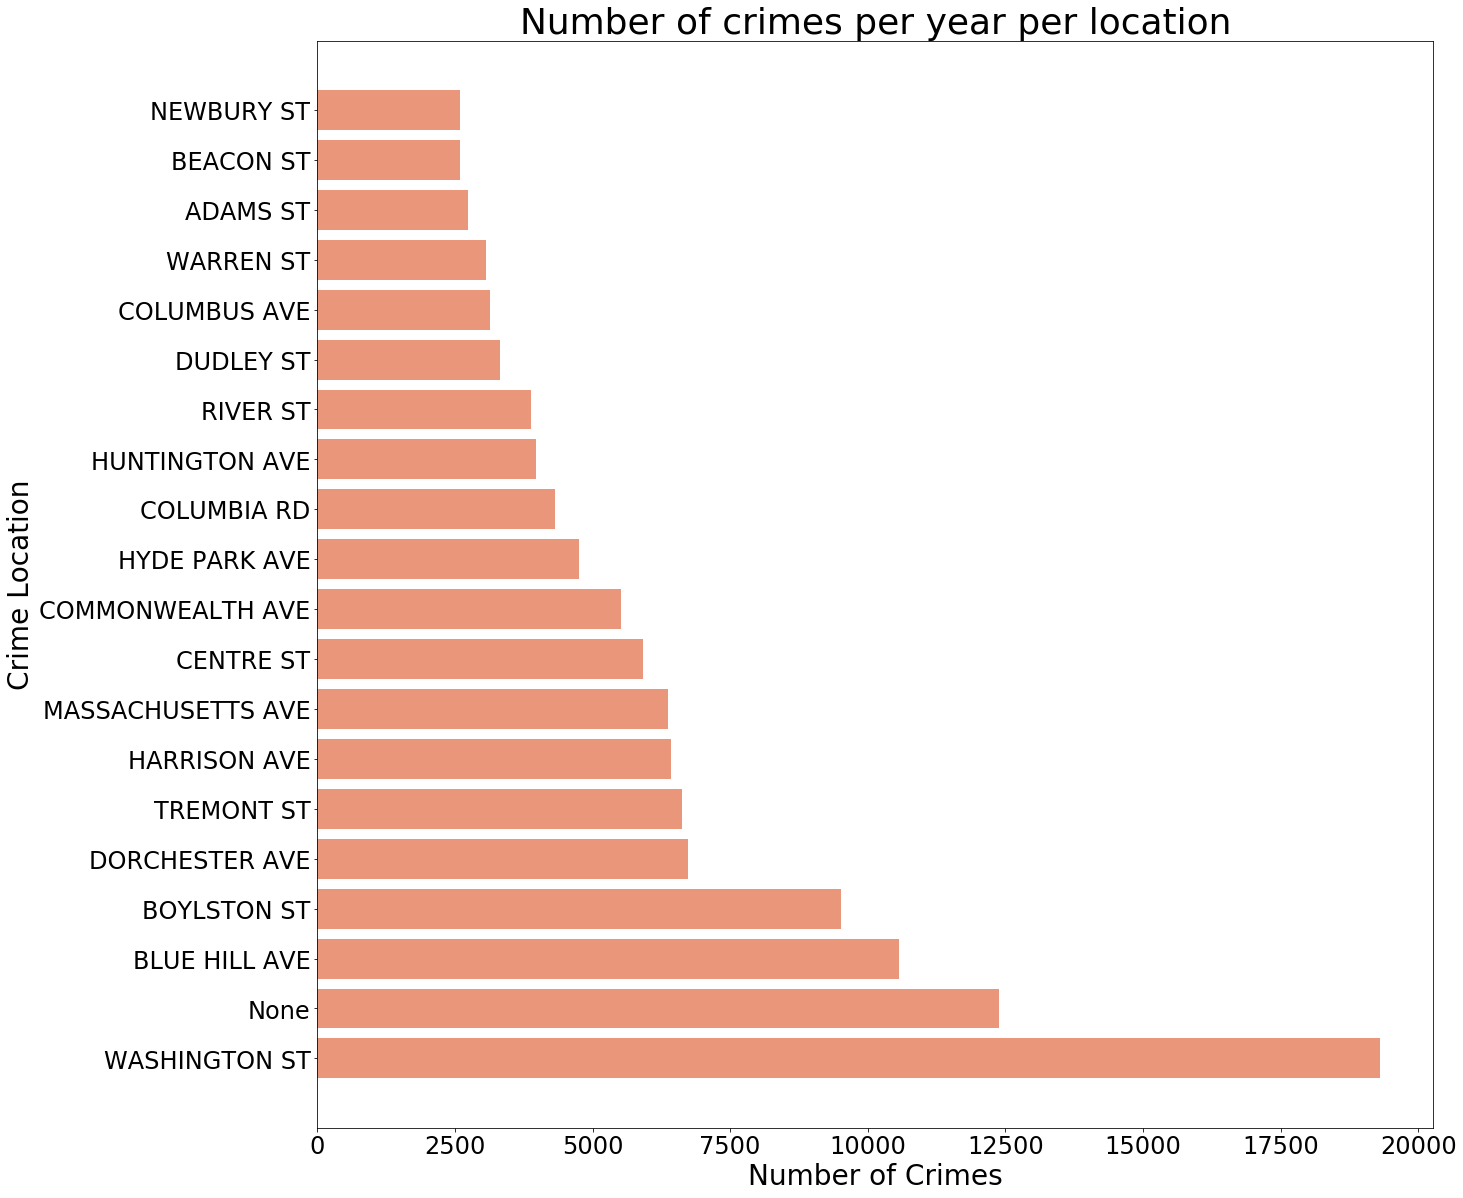

In [24]:
x_axis = [str(i) for i in location]
y_axis = [i for i in count]

fig = plt.figure(figsize=(20,20))
#fig.suptitle('Number of Crimes Per year per location', fontsize=36)

plt.title("Number of crimes per year per location", fontsize=36)
plt.xlabel("Number of Crimes", fontsize = 28)
plt.ylabel("Crime Location", fontsize = 28)
plt.barh(x_axis,y_axis,color = "darksalmon")
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()

In [25]:
crime_latitude  = crimes.groupBy("Lat").count().sort('count', ascending  = False).limit(20).collect()
crime_longitude  = crimes.groupBy("Long").count().sort('count', ascending  = False).limit(20).collect()
crime_coordinates = [crime_latitude,crime_longitude]


In [26]:
crime_latitude

[Row(Lat=None, count=29016),
 Row(Lat='42.34862382', count=1671),
 Row(Lat='42.36183857', count=1651),
 Row(Lat='42.28482577', count=1460),
 Row(Lat='42.32866284', count=1314),
 Row(Lat='42.25621592', count=1239),
 Row(Lat='42.29755533', count=1153),
 Row(Lat='42.34128751', count=1011),
 Row(Lat='42.33152148', count=995),
 Row(Lat='-1', count=927),
 Row(Lat='42.33511904', count=902),
 Row(Lat='42.32696647', count=888),
 Row(Lat='42.3523119', count=851),
 Row(Lat='42.30971857', count=848),
 Row(Lat='42.33954199', count=841),
 Row(Lat='42.35512339', count=803),
 Row(Lat='42.32696802', count=798),
 Row(Lat='42.33401829', count=763),
 Row(Lat='42.33428841', count=706),
 Row(Lat='42.34285014', count=702)]

In [27]:
crime_longitude

[Row(Long=None, count=29016),
 Row(Long='-71.08277637', count=1671),
 Row(Long='-71.05976489', count=1651),
 Row(Long='-71.09137369', count=1460),
 Row(Long='-71.08563401', count=1314),
 Row(Long='-71.12401947', count=1239),
 Row(Long='-71.0597091', count=1153),
 Row(Long='-71.05467933', count=1011),
 Row(Long='-71.07085307', count=995),
 Row(Long='-1', count=927),
 Row(Long='-71.0749171', count=902),
 Row(Long='-71.06198607', count=888),
 Row(Long='-71.0637051', count=851),
 Row(Long='-71.10429432', count=848),
 Row(Long='-71.06940877', count=841),
 Row(Long='-71.0608798', count=803),
 Row(Long='-71.08051941', count=798),
 Row(Long='-71.07638124', count=763),
 Row(Long='-71.07239518', count=706),
 Row(Long='-71.06516235', count=702)]

In [28]:
location_lat = [i for i in crime_latitude]
location_long = [i for i in crime_longitude]
location_count = [item[1] for item in crime_coordinates]

location_lat

[Row(Lat=None, count=29016),
 Row(Lat='42.34862382', count=1671),
 Row(Lat='42.36183857', count=1651),
 Row(Lat='42.28482577', count=1460),
 Row(Lat='42.32866284', count=1314),
 Row(Lat='42.25621592', count=1239),
 Row(Lat='42.29755533', count=1153),
 Row(Lat='42.34128751', count=1011),
 Row(Lat='42.33152148', count=995),
 Row(Lat='-1', count=927),
 Row(Lat='42.33511904', count=902),
 Row(Lat='42.32696647', count=888),
 Row(Lat='42.3523119', count=851),
 Row(Lat='42.30971857', count=848),
 Row(Lat='42.33954199', count=841),
 Row(Lat='42.35512339', count=803),
 Row(Lat='42.32696802', count=798),
 Row(Lat='42.33401829', count=763),
 Row(Lat='42.33428841', count=706),
 Row(Lat='42.34285014', count=702)]